In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
with open("d1_labels.txt", "r") as f:
    lines = f.readlines()

In [3]:
y_raw = np.array(lines, dtype=np.int32)

In [4]:
n = y_raw.shape[0]
x = np.zeros((n, 25, 80, 3), dtype=np.float32)
for i in tqdm(range(n)):
    x[i, :, :, :] = plt.imread("Dataset1/" + str(i + 1) + ".jpg")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 1617.00it/s]


In [5]:
yd1 = np.array(y_raw / 1000, dtype=np.int32)
yd2 = np.array((y_raw - yd1 * 1000) / 100, dtype=np.int32)
yd3 = np.array((y_raw - yd1 * 1000 - yd2 * 100) / 10, dtype=np.int32)
yd4 = np.array((y_raw - yd1 * 1000 - yd2 * 100 - yd3 * 10), dtype=np.int32)
y = np.vstack([yd1, yd2, yd3, yd4]).T # the first digit is between 1 and 9, we transform it to 0 to 8 for tensorflow's convinience. TODO: transform the model output in the end.

[8 4 4 5]


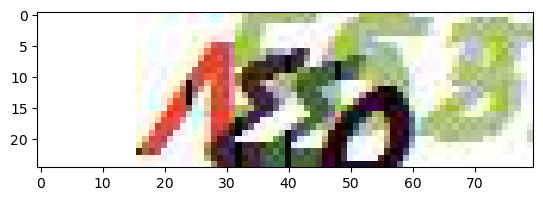

In [6]:
idx = np.random.randint(0, n)
plt.imshow(np.array(x[idx], dtype=np.int32))
print(y[idx])

In [7]:
import tensorflow as tf

In [8]:
x_l = tf.keras.layers.Input((25, 80, 3), dtype=tf.float32, name="x_input")
lc1 = tf.keras.layers.Conv2D(4, (3, 3), activation=tf.nn.leaky_relu) # 23, 78
lc2 = tf.keras.layers.Conv2D(4, (3, 3), activation=tf.nn.leaky_relu) # 21, 76
lc3 = tf.keras.layers.Conv2D(4, (3, 3), activation=tf.nn.leaky_relu) # 19, 74
lc4 = tf.keras.layers.Conv2D(4, (3, 3), activation=tf.nn.leaky_relu) # 17, 72
lc4 = tf.keras.layers.Conv2D(8, (3, 3), activation=tf.nn.leaky_relu) # 15, 70
lp1 = tf.keras.layers.MaxPooling2D(pool_size=(3, 3)) # 5, 24
lc5 = tf.keras.layers.Conv2D(8, (3, 3), activation=tf.nn.leaky_relu) # 3, 22
lc6 = tf.keras.layers.Conv2D(4, (3, 3), activation=tf.nn.leaky_relu) # 1, 20, (4)
lc1_7 = tf.keras.layers.Conv2D(4, (1, 1), activation=tf.nn.leaky_relu) # 1, 20, (4)
# Transpose: None, 1, 4, 20
lc1_8 = tf.keras.layers.Conv2D(10, (1, 1), activation=tf.nn.leaky_relu) # 1, 4, (10)
lc1_9 = tf.keras.layers.Conv2D(10, (1, 1), activation=tf.nn.leaky_relu) # 1, 4, (10)
lc1_10 = tf.keras.layers.Conv2D(20, (1, 1), activation=tf.nn.leaky_relu) # 1, 4, (20)
# Transpose: None, 1, 20, 4
c6_out = lc6(lc5(lp1(lc4(lc3(lc2(lc1(x_l))))))) # 1, 20, 4
A = tf.transpose(lc1_10(lc1_9(lc1_8(tf.transpose(lc1_7(c6_out), perm=[0, 1, 3, 2])))), perm=[0, 1, 3, 2])
A1 = tf.nn.softmax(A[:, :, :, 0:1], axis=2) # None, 1, 20, 1
A2 = tf.nn.softmax(A[:, :, :, 1:2], axis=2) # None, 1, 20, 1
A3 = tf.nn.softmax(A[:, :, :, 2:3], axis=2) # None, 1, 20, 1
A4 = tf.nn.softmax(A[:, :, :, 3:4], axis=2) # None, 1, 20, 1
Z1 = tf.multiply(A1, c6_out) # None, 1, 20, 4
Z2 = tf.multiply(A2, c6_out) # None, 1, 20, 4
Z3 = tf.multiply(A3, c6_out) # None, 1, 20, 4
Z4 = tf.multiply(A4, c6_out) # None, 1, 20, 4
GAP = tf.keras.layers.GlobalAveragePooling2D()
ld = tf.keras.layers.Dense(9, activation=tf.keras.activations.softmax) # 10
y1 = ld(GAP(Z1))
y2 = ld(GAP(Z2))
y3 = ld(GAP(Z3))
y4 = ld(GAP(Z4))
mdl = tf.keras.models.Model([x_l], {"y1": y1, "y2": y2, "y3": y3, "y4": y4})

In [9]:
mdl.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 x_input (InputLayer)           [(None, 25, 80, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 23, 78, 4)    112         ['x_input[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 21, 76, 4)    148         ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 19, 74, 4)    148         ['conv2d_1[0][0]']               
                                                                                              

In [10]:
mdl.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss={"y1": "sparse_categorical_crossentropy", "y2": "sparse_categorical_crossentropy", "y3": "sparse_categorical_crossentropy", "y4": "sparse_categorical_crossentropy"},
    metrics={"y1": "sparse_categorical_accuracy", "y2": "sparse_categorical_accuracy", "y3": "sparse_categorical_accuracy", "y4": "sparse_categorical_accuracy"}
)

In [11]:
val_split = 2500

In [12]:
mdl.fit(x={"x_input":x[:val_split]}, y={"y1":y[:val_split, 0], "y2":y[:val_split, 1], "y3":y[:val_split, 2], "y4":y[:val_split, 3]},
    validation_data=(x[val_split:], {"y1":y[val_split:, 0], "y2":y[val_split:, 1], "y3":y[val_split:, 2], "y4":y[val_split:, 3]}), batch_size=10, epochs=100, shuffle=True)

Epoch 1/100
250/250 [==============================] - 73s 283ms/step - loss: 8.7925 - dense_loss: 2.1851 - dense_1_loss: 2.2000 - dense_2_loss: 2.2037 - dense_3_loss: 2.2038 - dense_sparse_categorical_accuracy: 0.1300 - dense_1_sparse_categorical_accuracy: 0.1148 - dense_2_sparse_categorical_accuracy: 0.1032 - dense_3_sparse_categorical_accuracy: 0.1028 - val_loss: 8.7688 - val_dense_loss: 2.1742 - val_dense_1_loss: 2.1966 - val_dense_2_loss: 2.1959 - val_dense_3_loss: 2.2021 - val_dense_sparse_categorical_accuracy: 0.1860 - val_dense_1_sparse_categorical_accuracy: 0.1260 - val_dense_2_sparse_categorical_accuracy: 0.1260 - val_dense_3_sparse_categorical_accuracy: 0.0840
Epoch 2/100
250/250 [==============================] - 71s 284ms/step - loss: 8.6040 - dense_loss: 1.9703 - dense_1_loss: 2.1886 - dense_2_loss: 2.2001 - dense_3_loss: 2.2450 - dense_sparse_categorical_accuracy: 0.2888 - dense_1_sparse_categorical_accuracy: 0.1388 - dense_2_sparse_categorical_accuracy: 0.1216 - dense_3


KeyboardInterrupt



In [15]:
mdl.save("mdl_40_ep")

INFO:tensorflow:Assets written to: mdl_40_ep\assets


INFO:tensorflow:Assets written to: mdl_40_ep\assets


In [16]:
mdl.compile(
    optimizer=tf.keras.optimizers.Adam(0.0001),
    loss={"y1": "sparse_categorical_crossentropy", "y2": "sparse_categorical_crossentropy", "y3": "sparse_categorical_crossentropy", "y4": "sparse_categorical_crossentropy"},
    metrics={"y1": "sparse_categorical_accuracy", "y2": "sparse_categorical_accuracy", "y3": "sparse_categorical_accuracy", "y4": "sparse_categorical_accuracy"}
)

In [17]:
mdl.fit(x={"x_input":x[:val_split]}, y={"y1":y[:val_split, 0], "y2":y[:val_split, 1], "y3":y[:val_split, 2], "y4":y[:val_split, 3]},
    validation_data=(x[val_split:], {"y1":y[val_split:, 0], "y2":y[val_split:, 1], "y3":y[val_split:, 2], "y4":y[val_split:, 3]}), batch_size=10, epochs=40, shuffle=True)

Epoch 1/40
250/250 [==============================] - 72s 280ms/step - loss: 0.8125 - dense_loss: 0.0507 - dense_1_loss: 0.2001 - dense_2_loss: 0.3843 - dense_3_loss: 0.1774 - dense_sparse_categorical_accuracy: 0.9924 - dense_1_sparse_categorical_accuracy: 0.9408 - dense_2_sparse_categorical_accuracy: 0.8700 - dense_3_sparse_categorical_accuracy: 0.9576 - val_loss: 0.9880 - val_dense_loss: 0.0486 - val_dense_1_loss: 0.2557 - val_dense_2_loss: 0.4825 - val_dense_3_loss: 0.2012 - val_dense_sparse_categorical_accuracy: 0.9900 - val_dense_1_sparse_categorical_accuracy: 0.9100 - val_dense_2_sparse_categorical_accuracy: 0.8400 - val_dense_3_sparse_categorical_accuracy: 0.9420
Epoch 2/40
250/250 [==============================] - 69s 276ms/step - loss: 0.7770 - dense_loss: 0.0490 - dense_1_loss: 0.1892 - dense_2_loss: 0.3696 - dense_3_loss: 0.1692 - dense_sparse_categorical_accuracy: 0.9912 - dense_1_sparse_categorical_accuracy: 0.9456 - dense_2_sparse_categorical_accuracy: 0.8732 - dense_3_s


KeyboardInterrupt



In [19]:
mdl.evaluate(x[val_split:], {"y1":y[val_split:, 0], "y2":y[val_split:, 1], "y3":y[val_split:, 2], "y4":y[val_split:, 3]})

16/16 [==============================] - 1s 4ms/step - loss: 0.8980 - dense_loss: 0.0328 - dense_1_loss: 0.2576 - dense_2_loss: 0.4363 - dense_3_loss: 0.1712 - dense_sparse_categorical_accuracy: 0.9940 - dense_1_sparse_categorical_accuracy: 0.9100 - dense_2_sparse_categorical_accuracy: 0.8560 - dense_3_sparse_categorical_accuracy: 0.9420


[0.8980357646942139,
 0.032843515276908875,
 0.25763097405433655,
 0.43632185459136963,
 0.1712392419576645,
 0.9940000176429749,
 0.9100000262260437,
 0.8560000061988831,
 0.9419999718666077]

In [21]:
mdl.save("mdl_40_10_ep")

INFO:tensorflow:Assets written to: mdl_40_10_ep\assets


INFO:tensorflow:Assets written to: mdl_40_10_ep\assets


In [20]:
np.prod([0.9940000176429749,
 0.9100000262260437,
 0.8560000061988831,
 0.9419999718666077])

0.7293776555452306

In [27]:
m2 = tf.keras.models.load_model("mdl_40_10_ep/")

In [26]:
!conda list

# packages in environment at D:\Ana\envs\Captcha:
#
# Name                    Version                   Build  Channel
_tflow_select             2.3.0                       mkl  
abseil-cpp                20211102.0           hd77b12b_0  
absl-py                   2.1.0           py310haa95532_0  
aiohttp                   3.9.5           py310h2bbff1b_0  
aiosignal                 1.2.0              pyhd3eb1b0_0  
anyio                     4.2.0           py310haa95532_0  
argon2-cffi               21.3.0             pyhd3eb1b0_0  
argon2-cffi-bindings      21.2.0          py310h2bbff1b_0  
asttokens                 2.0.5              pyhd3eb1b0_0  
astunparse                1.6.3                      py_0  
async-lru                 2.0.4           py310haa95532_0  
async-timeout             4.0.3           py310haa95532_0  
attrs                     23.1.0          py310haa95532_0  
babel                     2.11.0          py310haa95532_0  
beautifulsoup4            4.12.3         

[2, 1, 5, 7]


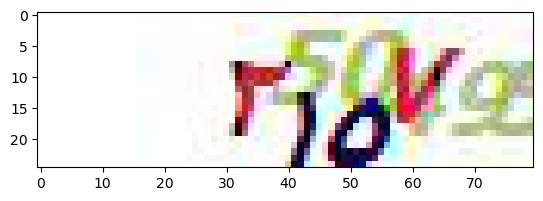

In [57]:
rnd = np.random.randint(2501, 3001)
y1 = mdl(x[rnd:rnd + 1])["y1"].numpy()
y2 = mdl(x[rnd:rnd + 1])["y2"].numpy()
y3 = mdl(x[rnd:rnd + 1])["y3"].numpy()
y4 = mdl(x[rnd:rnd + 1])["y4"].numpy()
print([np.argmax(y1), np.argmax(y2), np.argmax(y3), np.argmax(y4)])
plt.imshow(x[rnd] / 256)
plt.show()